In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
import seaborn
from geopandas import GeoDataFrame, GeoSeries, read_file
from geopandas.tools import sjoin
from shapely.geometry import Point
from pandas import to_numeric
from math import log

import jupynbimp
import restaurants_data_cleaning, review_data_process, census2010_data_cleaning, acs2013_data_cleaning

/opt/conda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


importing Jupyter notebook from restaurants_data_cleaning.ipynb
importing Jupyter notebook from review_data_process.ipynb
importing Jupyter notebook from review_data_getData.ipynb
importing Jupyter notebook from topic_dictionary.ipynb
importing Jupyter notebook from review_data_classify.ipynb
importing Jupyter notebook from review_data_topics_extractor.ipynb
importing Jupyter notebook from census2010_data_cleaning.ipynb
importing Jupyter notebook from acs2013_data_cleaning.ipynb


In [2]:
# Source CRS: WGS 84/Lat,Long; Projected CRS: WGS 84/UTM Zone 12N
CRS = {'GCS':'+init=epsg:4326', 'projected':'+init=epsg:32612'}
USE_CACHE=True
SQ_METERS_PER_SQ_KM=1000000
MARKET_AREA_RADIUS=3000

In [3]:
def normalizeByArea(geoDataFrame, column):
    return geoDataFrame.apply(
        lambda row: row[column]/row['area_sqkm'], axis=1
    ) 

## Transform data into consolidated shapefile

### Yelp Restaurants

In [ ]:
reviews = review_data_process.getData()

In [ ]:
restaurants = (restaurants_data_cleaning.getData(fromCache=USE_CACHE)
               .set_index('business_id')
               .join(reviews, how='inner')
               .reset_index()
              )

In [ ]:
restaurants.head()

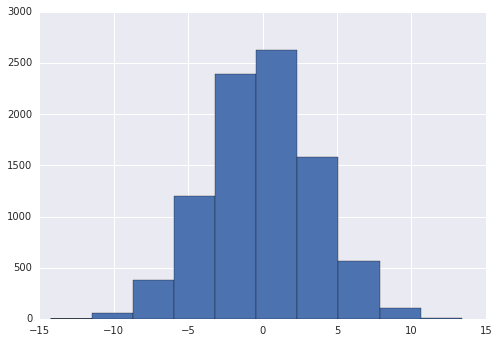

In [249]:
plot.figure()
restaurants['rating'].diff().hist()

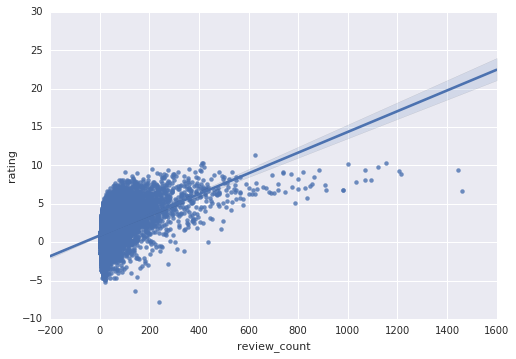

In [179]:
seaborn.regplot(restaurants['review_count'], restaurants['rating'])

In [181]:
restaurants['log_review_count'] = restaurants['review_count'].apply(lambda count: log(count)**2)

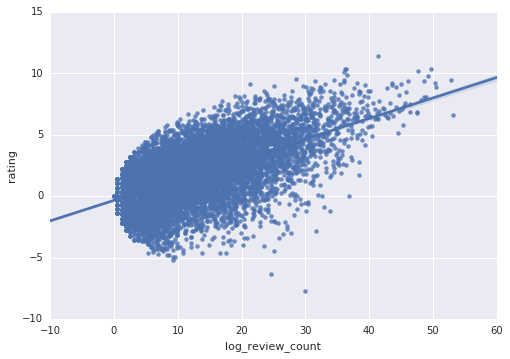

In [182]:
seaborn.regplot(restaurants['log_review_count'], restaurants['rating'])

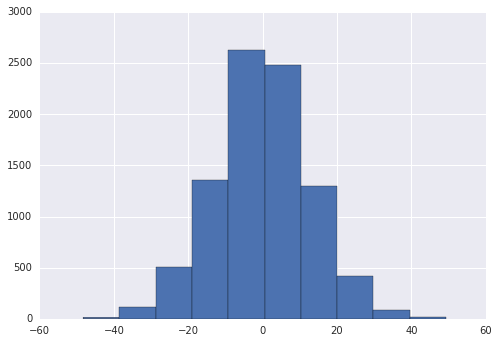

In [252]:
plot.figure()
restaurants['log_review_count'].diff().hist()

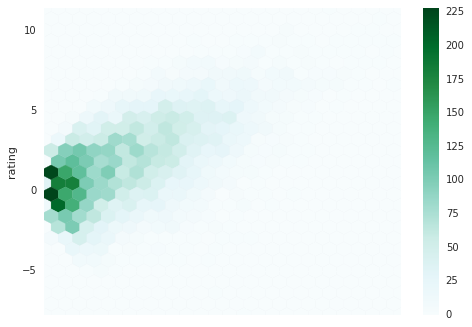

In [183]:
restaurants.plot.hexbin(x='log_review_count', y='rating', gridsize=25)

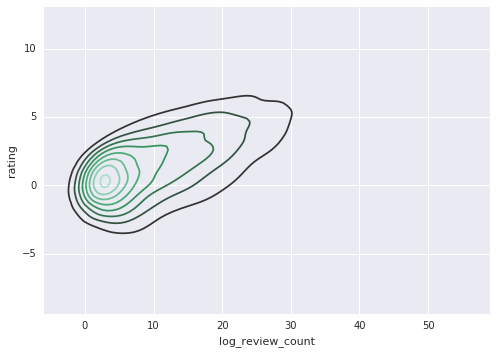

In [184]:
seaborn.kdeplot(restaurants['log_review_count'], restaurants['rating'])

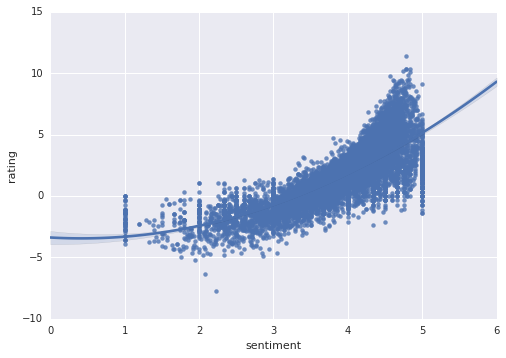

In [185]:
seaborn.regplot(restaurants['sentiment'], restaurants['rating'], order=2)

In [187]:
restaurants['sentiment_lin'] = restaurants['sentiment'].apply(lambda score: score**2)

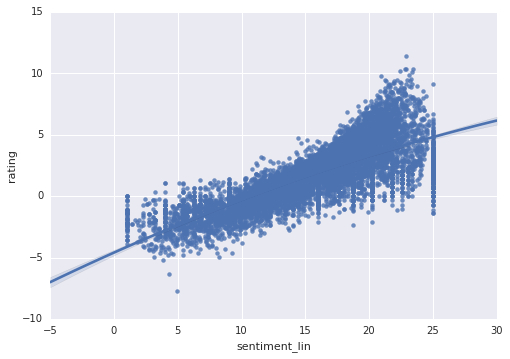

In [189]:
seaborn.regplot(restaurants['sentiment_lin'], restaurants['rating'], order=2)

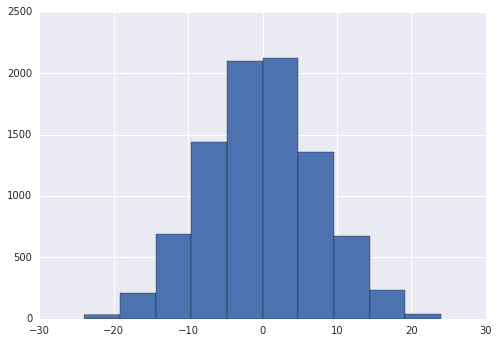

In [253]:
plot.figure()
restaurants['sentiment_lin'].diff().hist()

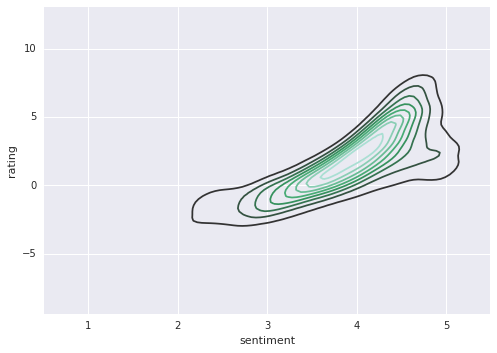

In [190]:
seaborn.kdeplot(restaurants['sentiment'], restaurants['rating'])

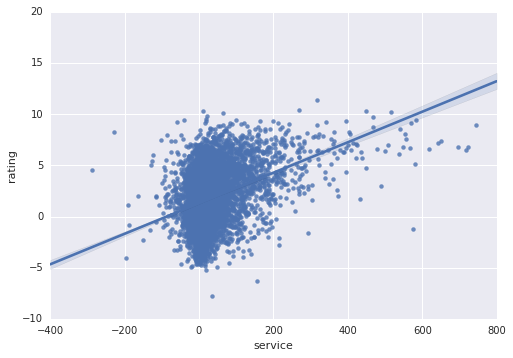

In [40]:
seaborn.regplot(restaurants['service'], restaurants['rating'])

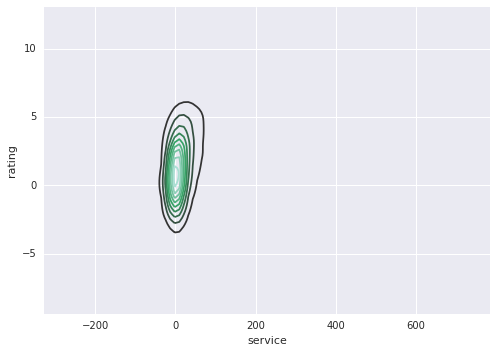

In [41]:
seaborn.kdeplot(restaurants['service'], restaurants['rating'])

In [196]:
restaurants['log_service'] = restaurants.apply(lambda row: (row['review_span'] * log(row['service'] + 1e3))**2, axis=1)

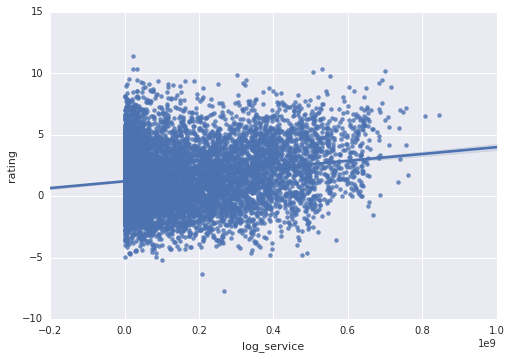

In [197]:
seaborn.regplot(restaurants['log_service'], restaurants['rating'])

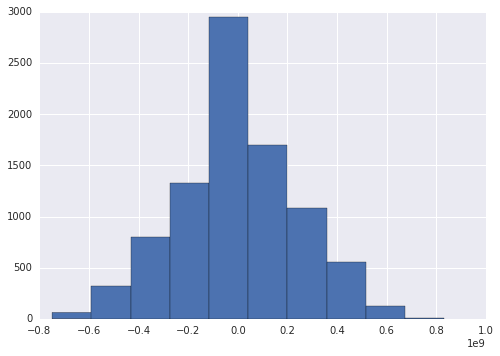

In [255]:
plot.figure()
restaurants['log_service'].diff().hist()

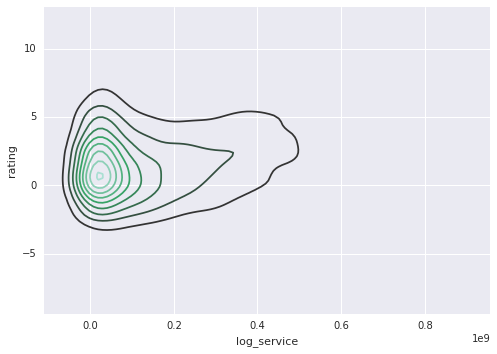

In [198]:
seaborn.kdeplot(restaurants['log_service'], restaurants['rating'])

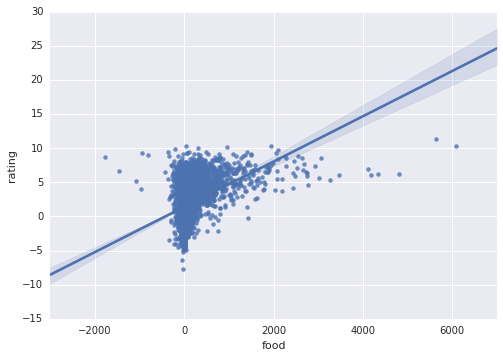

In [199]:
seaborn.regplot(restaurants['food'], restaurants['rating'])

In [286]:
restaurants['log_food'] = restaurants.apply(lambda row: (row['review_span'] * log(row['food'] + 1e4))**2, axis=1)

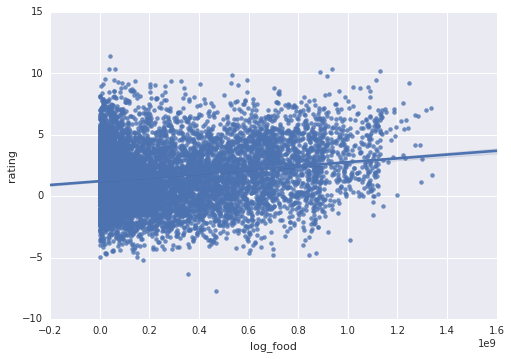

In [269]:
seaborn.regplot(restaurants['log_food'], restaurants['rating'], order=1)

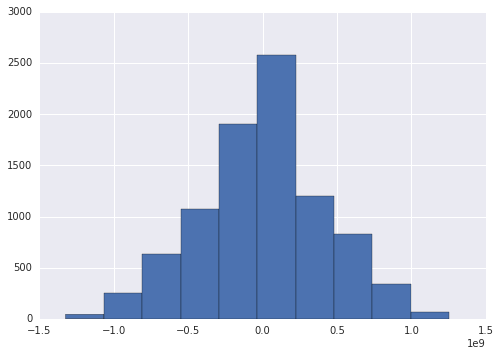

In [276]:
plot.figure()
restaurants['log_food'].diff().hist()

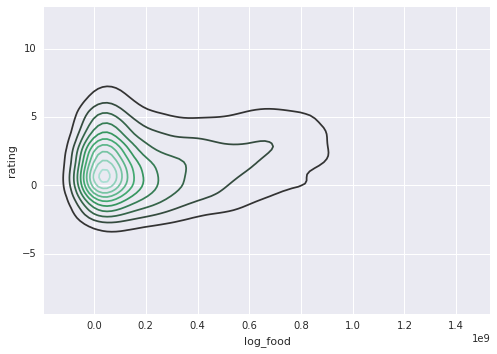

In [275]:
seaborn.kdeplot(restaurants['log_food'], restaurants['rating'])

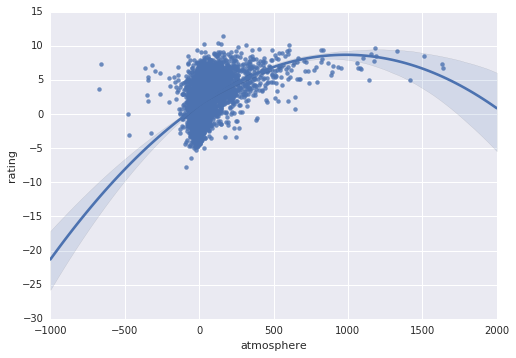

In [203]:
seaborn.regplot(restaurants['atmosphere'], restaurants['rating'], order=2)

In [287]:
restaurants['log_atmosphere'] = restaurants.apply(lambda row: (row['review_span'] * log(row['atmosphere'] + 1e4))**2, axis=1)

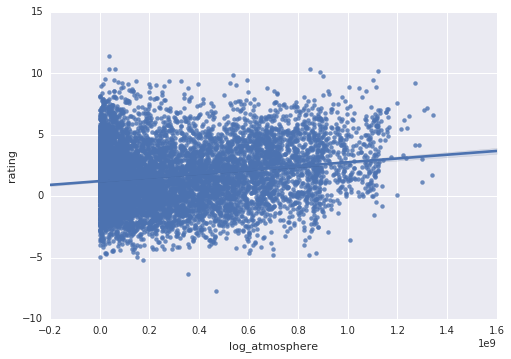

In [288]:
seaborn.regplot(restaurants['log_atmosphere'], restaurants['rating'], order=1)

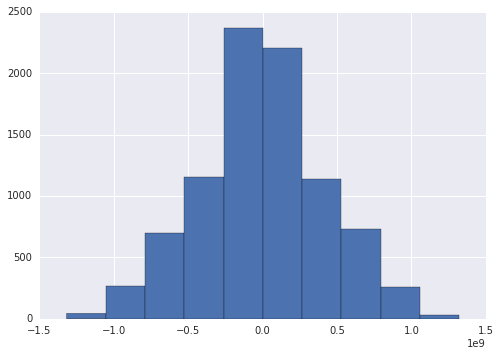

In [289]:
plot.figure()
restaurants['log_atmosphere'].diff().hist()

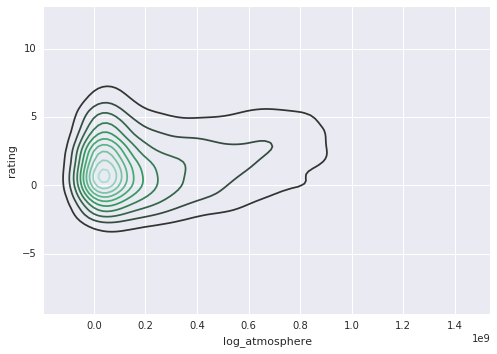

In [290]:
seaborn.kdeplot(restaurants['log_atmosphere'], restaurants['rating'])

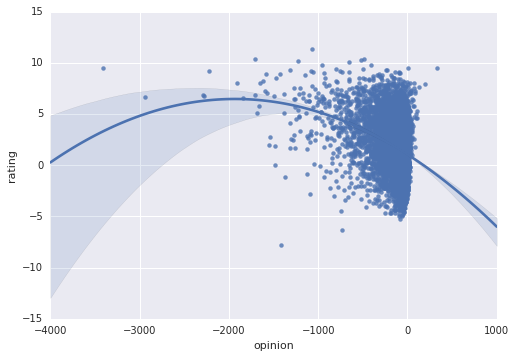

In [191]:
seaborn.regplot(restaurants['opinion'], restaurants['rating'], order=2)

In [193]:
restaurants['log_opinion'] = restaurants.apply(lambda row: (row['review_span'] * log(row['opinion'] + 1e4))**2, axis=1)

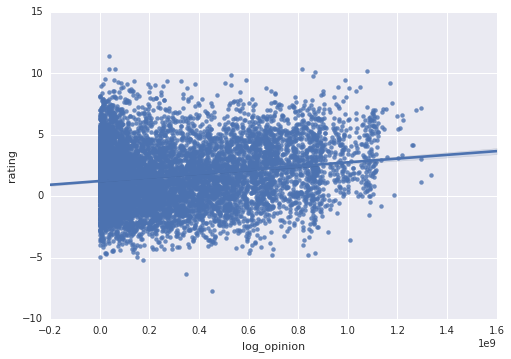

In [219]:
seaborn.regplot(restaurants['log_opinion'], restaurants['rating'], order=1)

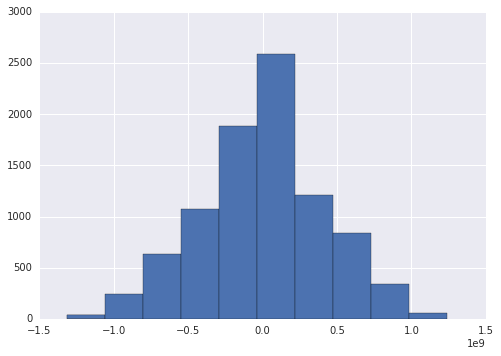

In [278]:
plot.figure()
restaurants['log_opinion'].diff().hist()

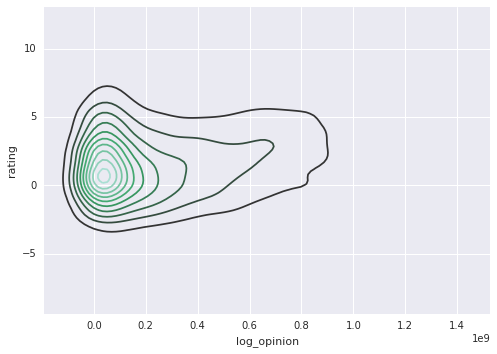

In [220]:
seaborn.kdeplot(restaurants['log_opinion'], restaurants['rating'])

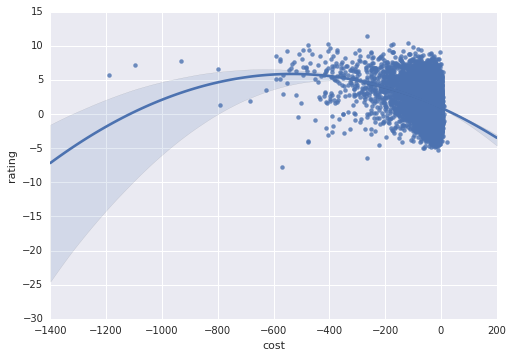

In [239]:
seaborn.regplot(restaurants['cost'], restaurants['rating'], order=2)

In [281]:
restaurants['log_cost'] = restaurants.apply(lambda row: (row['review_span'] * log(row['cost'] + 1e4))**2, axis=1)

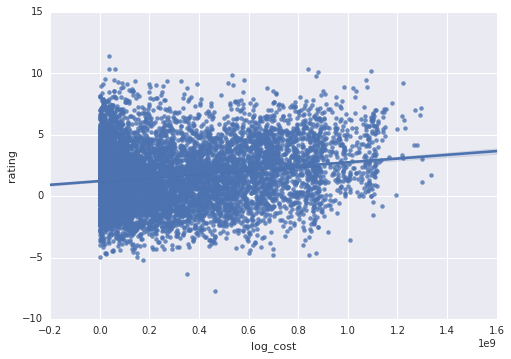

In [282]:
seaborn.regplot(restaurants['log_cost'], restaurants['rating'], order=1)

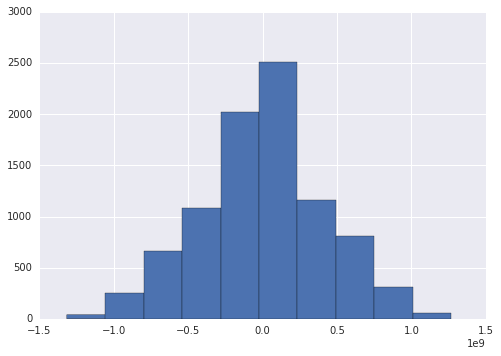

In [283]:
plot.figure()
restaurants['log_cost'].diff().hist()

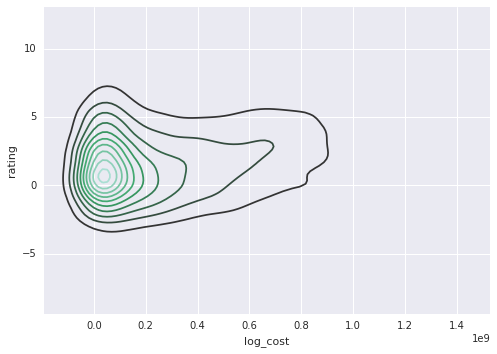

In [284]:
seaborn.kdeplot(restaurants['log_cost'], restaurants['rating'])

In [11]:
restaurants = GeoDataFrame(
    restaurants,
    geometry=[Point(x,y) 
              for x, y in zip(restaurants['longitude'],
                              restaurants['latitude'])
             ],
    crs=CRS['GCS']
)
restaurants.to_crs(CRS['projected'], inplace=True)
restaurants.drop(['latitude', 'longitude'], axis=1, inplace=True)

### Restaurant Proximity Variables 

In [12]:
# Phoenix Convention Center in projected coordinates
phoenixCBD = GeoSeries(Point(400557, 3701492), crs=CRS['projected'])

restaurants['dist_CBD'] = restaurants.geometry.apply(
    lambda point: phoenixCBD.distance(point)
)

In [13]:
# Retrieved 17/07/2016 from http://download.geofabrik.de/north-america/us/arizona.html
motorwayExits = read_file('/arizona-latest/roads.shp', 
                          vfs='zip://../data/shapefiles/arizona-latest.zip'
                         ).to_crs(CRS['projected'])

motorwayExits = (motorwayExits[motorwayExits['type'] == 'motorway_link'])

restaurants['dist_mwy_exit'] = restaurants.geometry.apply(
    lambda point: motorwayExits.distance(point).min()
)

In [14]:
restaurants['competitors'] = restaurants.geometry.apply(
    lambda point: sum(restaurants.intersects(point.buffer(MARKET_AREA_RADIUS)))-1
)

### Census 2010

In [15]:
census2010 = census2010_data_cleaning.getData(fromCache=USE_CACHE)

# Retrieved 10-07-2016 from https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=Block+Groups
blockGroups2010 = read_file('/tl_2010_04_bg10.shp', 
                            vfs='zip://../data/shapefiles/tl_2010_04_bg10.zip')
blockGroups2010.GEOID10 = to_numeric(blockGroups2010.GEOID10)
blockGroups2010 = (blockGroups2010[['GEOID10','geometry']]
                   .rename(columns={'GEOID10':'GEOID'})
                   .to_crs(CRS['projected'])
                  )
blockGroups2010['area_sqkm'] = blockGroups2010.geometry.area/SQ_METERS_PER_SQ_KM 
blockGroups2010 = blockGroups2010.merge(census2010, on='GEOID')
   
# Normalize count data by block group area
blockGroups2010['population_density'] = normalizeByArea(blockGroups2010,'population_total')
blockGroups2010['home_mortgage_density'] = normalizeByArea(blockGroups2010,'home_mortgages')
blockGroups2010['home_owner_density'] = normalizeByArea(blockGroups2010,'home_owners')
blockGroups2010['renter_density'] = normalizeByArea(blockGroups2010,'renters')
blockGroups2010['household_density'] = normalizeByArea(blockGroups2010,'total_households')
blockGroups2010['family_household_density'] = normalizeByArea(blockGroups2010,'family_households')
blockGroups2010['single_household_density'] = normalizeByArea(blockGroups2010,'single_households')
blockGroups2010['hispanic_latino_population_density'] = normalizeByArea(blockGroups2010,'population_hispanic_latino')
blockGroups2010['white_population_density'] = normalizeByArea(blockGroups2010,'population_white')
blockGroups2010['black_population_density'] = normalizeByArea(blockGroups2010,'population_black')
blockGroups2010['native_american_population_density'] = normalizeByArea(blockGroups2010,'population_native_american')
blockGroups2010['asian_population_density'] = normalizeByArea(blockGroups2010,'population_asian')

blockGroups2010.drop(['population_total',
                      'home_mortgages',
                      'home_owners',
                      'renters',
                      'total_households',
                      'family_households',
                      'single_households','population_hispanic_latino',
                      'population_white',
                      'population_black',
                      'population_native_american',
                      'population_asian'
                     ], 
                     axis=1, inplace=True
                    )

### ACS 2013

In [16]:
acs2013 = acs2013_data_cleaning.getData(fromCache=USE_CACHE) 

# Retrieved 10-07-2016 https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2013&layergroup=Block+Groups
blockGroups2013 = read_file('/tl_2013_04_bg.shp', 
                            vfs='zip://../data/shapefiles/tl_2013_04_bg.zip')
blockGroups2013.GEOID = to_numeric(blockGroups2010.GEOID)
blockGroups2013 = (blockGroups2013[['GEOID','geometry']]
                   .to_crs(CRS['projected'])
                  )

blockGroups2013['area_sqkm'] = blockGroups2013.geometry.area/SQ_METERS_PER_SQ_KM 
blockGroups2013 = blockGroups2013.merge(acs2013, on='GEOID')
  
# Normalize count data by block group area
blockGroups2013['density_education_highschool'] = normalizeByArea(blockGroups2013,'education_highschool')
blockGroups2013['density_education_undergraduate'] = normalizeByArea(blockGroups2013,'education_undergraduate')
blockGroups2013['density_education_postgraduate'] = normalizeByArea(blockGroups2013,'education_postgraduate')

blockGroups2013.drop(['education_highschool',
                      'education_undergraduate',
                      'education_postgraduate'
                     ], 
                     axis=1, inplace=True
                    )

## Spatial Join Restaurant Locations on Census Block Groups

In [17]:
restaurants_census2010 = (sjoin(restaurants[['business_id', 'geometry']], blockGroups2010, how='inner')
                          .drop(['geometry', 'index_right', 'GEOID', 'area_sqkm'], axis=1)
                         )
restaurants_acs2013 = (sjoin(restaurants[['business_id', 'geometry']], blockGroups2013, how='inner')
                       .drop(['geometry', 'index_right', 'GEOID', 'area_sqkm'], axis=1)
                      )
restaurants = GeoDataFrame(restaurants_census2010.merge(restaurants_acs2013, on='business_id')
                           .merge(restaurants, on='business_id'), 
                           crs=CRS['projected']
                          )

## Save as shapefile

In [18]:
# shorten names for ESRI compatability
restaurants.rename(columns={'business_id':'bus_id',
                            'average_household_size':'avg_hshld',
                            'population_density':'pop_skqm',
                            'home_mortgage_density':'mortg_skqm',
                            'home_owner_density':'hmown_sqkm',
                            'renter_density':'rent_sqkm',
                            'household_density':'hshld_sqkm',
                            'family_household_density':'fmly_sqkm',
                            'single_household_density':'sngl_sqkm',
                            'hispanic_latino_population_density':'hisp_sqkm',
                            'white_population_density':'white_sqkm',
                            'black_population_density':'black_sqkm',
                            'native_american_population_density':'natam_sqkm',
                            'asian_population_density':'asian_sqkm',
                            'median_home_value':'med_hm_val',
                            'median_household_income':'med_income',
                            'density_education_highschool':'ed_hs_sqkm',
                            'density_education_undergraduate':'ed_ug_sqkm',
                            'density_education_postgraduate':'ed_pg_sqkm',
                            'full_address':'address',
                            'price_range':'price_rng',
                            'waiter_service':'waiter_svc',
                            'outdoor_seating':'outdr_seat',
                            'review_span':'revw_span',
                            'dist_mwy_exit':'near_exit',
                            'competitors':'num_cmptrs'
                           }, inplace=True
                  )

restaurants.to_file('../data/shapefiles/restaurants/restaurants.shp')